In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
SPLIT_WEIGHTS = (8, 1, 1)
# splits = tfds.Split.TRAIN.subsplit(weighted = SPLIT_WEIGHTS)
(raw_train, raw_validation, raw_test), metadata = tfds.load('horses_or_humans',  split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
                                                           with_info = True, as_supervised = True)

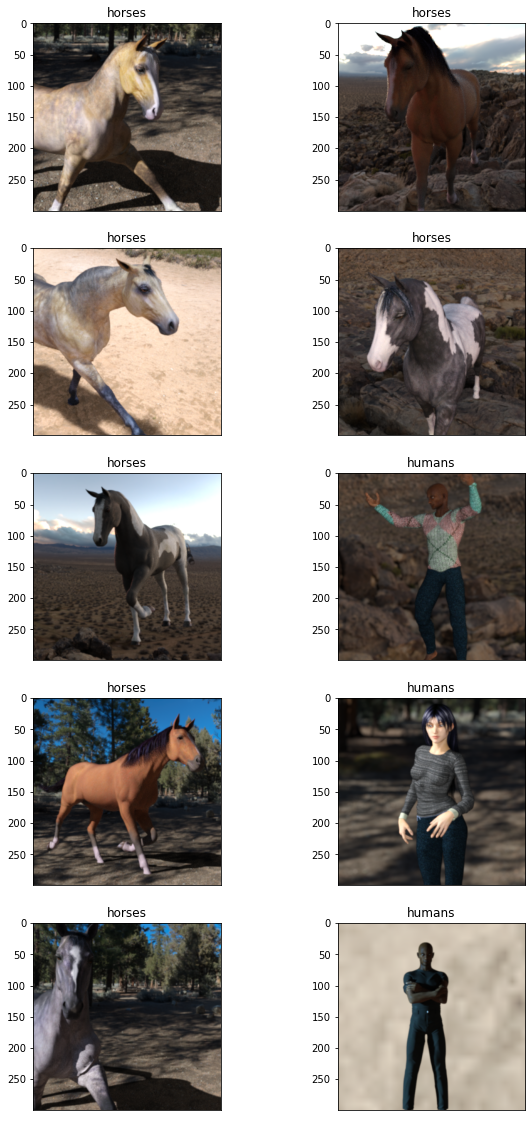

In [3]:
get_label_name = metadata.features['label'].int2str

def show_images(dataset):
    i=0
    fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (10,20))
    for image, label in dataset.take(10):
        axes[i%5][(i//5)%5].imshow(image)
        axes[i%5][(i//5)%5].set_title(get_label_name(label))
        axes[i%5][(i//5)%5].set_xticks([])
        axes[i%5][(i//5)%5].set_xticks([])
        i+=1
        
show_images(raw_train)

In [4]:
"""Then we resize the images to (160×160) with color values in the range [-1,1] which is
what MobileNetV2 expects as input:"""

IMG_SIZE = 160
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) -  1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [5]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [6]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 2000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)

In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (160,160,3), include_top = False, weights = 'imagenet')

base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [8]:
for image_batch, label_batch in train_batches.take(1):
    pass
print(image_batch.shape)
print(label_batch.shape)

(32, 160, 160, 3)
(32,)


In [9]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [11]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [19]:
model = tf.keras.Sequential([
    base_model, global_average_layer, prediction_layer
])

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])

In [21]:
num_train, num_val, num_test = (metadata.splits['train'].num_examples*weight/10 for weight in SPLIT_WEIGHTS)

In [22]:
print(num_train, num_val, num_test)

821.6 102.7 102.7


In [23]:

initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 4

In [24]:
loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
print(loss0, accuracy0)

4/4 [==============================] - 2s 149ms/step - loss: 5.3238 - accuracy: 0.5686
5.323820114135742 0.5686274766921997


In [25]:
history = model.fit(train_batches, epochs=initial_epochs,validation_data=validation_batches)

Epoch 1/10
26/26 [==============================] - 9s 244ms/step - loss: 5.8648 - accuracy: 0.5024 - val_loss: 4.8776 - val_accuracy: 0.5882
Epoch 2/10
26/26 [==============================] - 7s 248ms/step - loss: 5.0072 - accuracy: 0.5523 - val_loss: 4.8614 - val_accuracy: 0.5882
Epoch 3/10
26/26 [==============================] - 7s 248ms/step - loss: 4.0999 - accuracy: 0.5876 - val_loss: 3.7218 - val_accuracy: 0.5882
Epoch 4/10
26/26 [==============================] - 7s 246ms/step - loss: 2.9759 - accuracy: 0.6387 - val_loss: 3.4614 - val_accuracy: 0.6275
Epoch 5/10
26/26 [==============================] - 7s 246ms/step - loss: 2.4749 - accuracy: 0.6861 - val_loss: 3.0325 - val_accuracy: 0.6569
Epoch 6/10
26/26 [==============================] - 7s 240ms/step - loss: 2.0818 - accuracy: 0.7348 - val_loss: 2.5663 - val_accuracy: 0.7255
Epoch 7/10
26/26 [==============================] - 7s 250ms/step - loss: 1.7846 - accuracy: 0.7762 - val_loss: 2.3252 - val_accuracy: 0.7549
Epoch 